The [Conversation AI team](https://conversationai.github.io/), a research initiative founded by [Jigsaw](https://jigsaw.google.com/) and Google (both a part of Alphabet) are working on tools to help improve online conversation. One area of focus is the study of negative online behaviors, like toxic comments (i.e. comments that are rude, disrespectful or otherwise likely to make someone leave a discussion). So far they’ve built a range of publicly available models served through the Perspective API, including toxicity. But the current models still make errors, and they don’t allow users to select which types of toxicity they’re interested in finding (e.g. some platforms may be fine with profanity, but not with other types of toxic content).

Hence, the goal is to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, identity-based hate etc.

## What data are we going to use ?

We have a dataset of comments from [Wikipedia's Talk Pages](https://en.wikipedia.org/wiki/Help:Talk_pages). The comments have been labeled by human raters for toxic behavior. The types of toxicity are:
    1. toxic
    2. severe_toxic
    3. obscene
    4. threat
    5. insult
    6. identity_hate
    
Source - https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview

**Disclaimer - The dataset contains text that may be considered profane, vulgar, or offensive.**

In [13]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

In [1]:
from collections import Counter
import re
import string

import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from tqdm.notebook import tqdm

tqdm.pandas()
# import nltk
# nltk.download("stopwords")

In [2]:
data = pd.read_csv("data/train.csv")
display(data.head())

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Let's understand the given data a bit more

In [3]:
n = data.shape[0]
print("Number of rows in the dataset : {}".format(n))
n_null = data[data.isna().any(axis = 1)].shape[0]
print("Number of rows in the dataset with one or more NA values: {}".format(n_null))

Number of rows in the dataset : 159571
Number of rows in the dataset with one or more NA values: 0


##### What's the distribution of comments for each of the 6 categories?

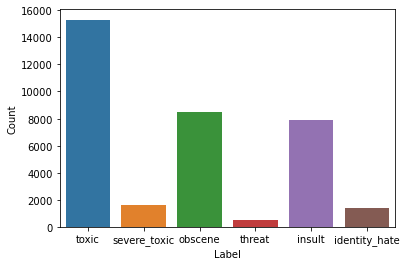

In [4]:
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
category_counts = data[labels].sum(axis = 0)
category_counts_df = pd.DataFrame({"Label" : category_counts.index, "Count" : category_counts.values})
ax = sns.barplot(data = category_counts_df, x = "Label", y = "Count")

##### Do we have messages with more than one label marked ?

'Number of Comments which do not have any label marked : 143346 (89.83%)'

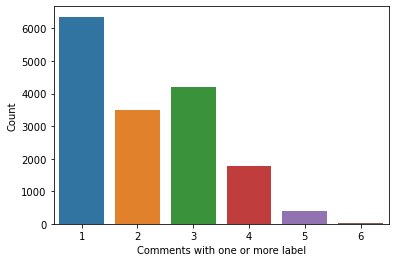

In [5]:
counts = data[labels].sum(axis = 1)
counts_df = pd.DataFrame({"Comments with one or more label" : counts.value_counts().index, "Count" : counts.value_counts().values})
no_label_count = counts_df[counts_df["Comments with one or more label"] == 0]["Count"].values[0]
display("Number of Comments which do not have any label marked : {} ({}%)".format(no_label_count, round(100 * no_label_count/data.shape[0], 2)))
ax = sns.barplot(data = counts_df[counts_df["Comments with one or more label"] > 0], x = "Comments with one or more label", y = "Count")
plt.show()

##### What about toxic and severe_toxic category ? They seem related.

In [6]:
display(pd.crosstab(data["toxic"], data["severe_toxic"]))
display("Comments which are marked as sever_toxic are also marked as toxic. Hence the comments with severe_toxic category "
        "is a subset of comments with toxic category.")

severe_toxic,0,1
toxic,,
0,144277,0
1,13699,1595


'Comments which are marked as sever_toxic are also marked as toxic. Hence the comments with severe_toxic category is a subset of comments with toxic category.'

##### How do the messages look like ?

In [7]:
display("Examples of comments within toxic category - ")
display(data[data["toxic"] == 1]["comment_text"].values[2])
display(data[data["toxic"] == 1]["comment_text"].values[12])

'Examples of comments within toxic category - '

"Bye! \n\nDon't look, come or think of comming back! Tosser."

'Hi! I am back again!\nLast warning!\nStop undoing my edits or die!'

In [8]:
display("Examples of comments within threat category - ")
display(data[data["threat"] == 1]["comment_text"].values[5])
display(data[data["threat"] == 1]["comment_text"].values[13])

'Examples of comments within threat category - '

'Whoever put a notices on my page. I will kill u'

"WHAT'S WRONG WITH YOU?\nGO KILL YOURSELF, YOU VILE CREATURE!!!!!!!!!!!"

##### What are most commonly used words for each of the labels ? 
**This section can be skipped, as it contains words which might be vulgar, profane or offensive.**

In [9]:
def preprocess_comment(comment, remove_stopwords = True, english_stopwords = None):
    """
    This function would process the comment string. It mainly performs the following actions - 
    1. Remove all the punctuations from the string.
    2. Transform the string to contain only lowercase alphabets. 
    3. Remove the stop-words from the string. (Optional)
    """
    comment = re.sub(f"[{string.punctuation}\s+]", " ", comment) # Replace all punctuation marks and whitespace characters with a single space.
    comment = comment.lower() # Converts the string to lowercase.
    
    if(remove_stopwords):
        comment = " ".join(filter(lambda x : x not in english_stopwords, comment.split())) # Removes stopwords from the string
    return comment

In [10]:
english_stopwords = stopwords.words("english")
data["processed_comment_text"] = data["comment_text"].progress_apply(lambda x : preprocess_comment(x, True, english_stopwords))

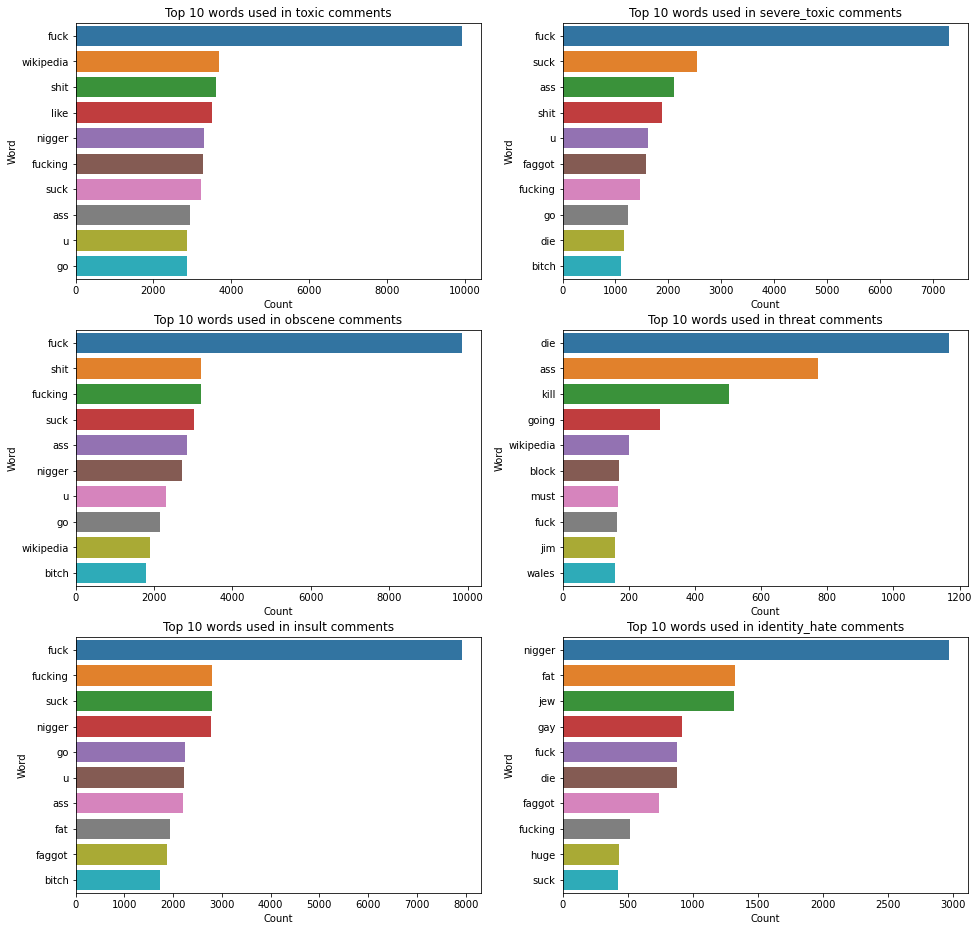

In [11]:
fig, axes = plt.subplots(3,2, figsize = (16,16))
for label, ax in zip(labels, axes.flatten()):
    all_comments = data[data[label] == 1]["processed_comment_text"].values
    df_word_counts = pd.DataFrame(sorted(dict(Counter(" ".join(all_comments).split(" "))).items(), key = lambda x : x[1], reverse = True)[:10])
    df_word_counts.columns = ["Word", "Count"]
    sns.barplot(data=df_word_counts, x = "Count", y ="Word", ax = ax).set_title("Top 10 words used in {} comments".format(label))
plt.show()

## How do we represent these comments as numbers (or vector of numbers) ?

Most of the Machine Learning models do not accept text as input. Instead they expect numbers (or vector of numbers) as features. So the question arises - How do we convert comments (strings) into numbers ?

### Bag-of-Words representation

A bag-of-words (BoW) model is a way of extracting features from text, which can be then used by Machine Learning models. Is is quite simple and flexible.

To create a BoW representation of a textual input, we mainly conisder the following two things - 
1. A vocabulary of known words - This can be all the unique words in the given corpus.
2. A measure of presence of words - This can be the count of number of times a word is present in the given text.
   
   
Eg - 
Let the corpus contain the following 3 sentences - 
    1. It was the best of times
    2. It was the worst of times
    3. It was the age of wisdom and the age of foolishness
    
Considering the above 3 sentences the vocabulary consist of following words (punctuation and case is ignored) -
    * it
    * was
    * the
    * best
    * of
    * times
    * worst
    * age
    * wisdom
    * and
    * foolishness
    
Once the vocabulary is known, the BoW representation of the text is just the frequencty of each word in the vocabulary for the text. 
Hence, the BoW representation for the 1st sentence in the corpus is - 

**Sentence** | it | was | the | best | of | times | worst | age | wisdom | and | foolishness
:--- | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---:
**It was the best of times** | 1 | 1 | 1 | 1 | 1 | 1 | 0 | 0 | 0 | 0 | 0

Similarly for other sentences in the corpus - 

**Sentence** | it | was | the | best | of | times | worst | age | wisdom | and | foolishness
:--- | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---:
**It was the best of times** | 1 | 1 | 1 | 1 | 1 | 1 | 0 | 0 | 0 | 0 | 0
**It was the worst of times** | 1 | 1 | 1 | 0 | 1 | 1 | 1 | 0 | 0 | 0 | 0
**It was the age of wisdom and the age of foolishness** | 1 | 1 | 2 | 0 | 2 | 0 | 0 | 2 | 1 | 1 | 1

The above matrix of BoW representation can now be used to train any ML model. Sklearn has a flexible implemenation of BoW model, you can read more about it [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer).

To numerically represnt a text, we usually compute a score for each word to signify its importance in the text and corpus. In BoW, the score is simply the frequency of the word. 

A problem with BoW model is that the highly frequent words start to dominate in the document (in NLP we generally refere each text input as a document), but it may not contain as much information as the rarer words. One approach to fix this is by scaling the frequency of words by how often they appear in all the documents, hence penalizing the most common words like 'the', 'was', 'it' etc from the above example. This approach is called *Term Frequency - Inverse Document Frequency (TF-IDF)*

### Term Frequency - Inverse Document Frequency (TF-IDF) representation

TF-IDF is yet another way to numerically represent a text by looking at the words present in the text. TF-IDF value for a word in a text increases proportinally to the number of times a word appears in the text and is offset by the number of texts in the corpus that contain the word, this helps adjust for the words that appear more frequently in general.

TF-IDF is a product of two statistics - 

**1. Term Frequency (TF)** - It is simply the count of a word in a given text. As the length of the text can varry, TF is generally divided by the number of words in the text. Therefore, the term-frequency for a term $t$ in a document $d$ can be calculated as - 

$$tf(t,d) = \frac{f_{t,d}}{\sum_{t' \in d} f_{t',d}} $$

Here, 
* $f_{t,d}$ is the count of term $t$ in document $d$

The TF for the above example is - 

In [14]:
def get_tf(documents):
    vocabulary = []
    for d in documents:
        vocabulary.extend(d.split())
    vocabulary = list(set(vocabulary))
    tf = {}
    for d in documents:
        tf[d] = {}
        for w in vocabulary:
            tf[d][w] = d.split().count(w) / len(d.split())
    
    return pd.DataFrame(tf).T

corpus = [ 
    "it was the best of times",
    "it was the worst of times",
    "it was the age of wisdom and the age of foolishness"
]

tf = get_tf(corpus)
tf = tf[["it", "was", "the", "best", "of", "times", "worst", "age", "wisdom", "and", "foolishness"]]
display(tf)

hide_toggle()

,it,was,the,best,of,times,worst,age,wisdom,and,foolishness
it was the best of times,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000
it was the worst of times,0.166667,0.166667,0.166667,0.000000,0.166667,0.166667,0.166667,0.000000,0.000000,0.000000,0.000000
it was the age of wisdom and the age of foolishness,0.090909,0.090909,0.181818,0.000000,0.181818,0.000000,0.000000,0.181818,0.090909,0.090909,0.090909


**2. Inverse Document Frequency** - It is the measure of how much information the word provides, i.e., if it is a common or rare across all documents. Mathematically, it is the logarithmically scaled inverse fraction of the documents that contain the word. For rare words, IDF value naturally becomes higher and for common words it becomes smaller. The log factor hels dampen the IDF value for large corpuses. The Inverse Document Frequency of a term $t$ in a cospus set $D$ can be caluclated as - 
$$idf(t,D) = log(\frac{N}{|{d \in D : t \in d}|})$$

Here,
* $N$ is the total number of documents in the corpus.
* $|{d \in D : t \in d}|$ is the number of documents where word $t$ occurs.

The IDF for the above mentioned example is - 

In [15]:
def get_idf(documents):
    vocabulary = []
    for d in documents:
        vocabulary.extend(d.split())
    vocabulary = list(set(vocabulary))
    
    df = {}
    for w in vocabulary:
        df[w] = 0
        for d in documents:
            if w in d:
                df[w] = df[w] + 1
    idf_words = {}
    for k,v in df.items():
        idf_words[k] = np.log(len(documents)/v)
    
    idf = {}
    for d in documents:
        idf[d] = {}
        for w in vocabulary:
            if w in d:
                idf[d][w] = idf_words[w]
            else:
                idf[d][w] = 0
    return pd.DataFrame(idf).T

corpus = [ 
    "it was the best of times",
    "it was the worst of times",
    "it was the age of wisdom and the age of foolishness"
]

idf = get_idf(corpus)
idf = idf[["it", "was", "the", "best", "of", "times", "worst", "age", "wisdom", "and", "foolishness"]]
display(idf)

hide_toggle()

,it,was,the,best,of,times,worst,age,wisdom,and,foolishness
it was the best of times,0.0,0.0,0.0,1.098612,0.0,0.405465,0.000000,0.000000,0.000000,0.000000,0.000000
it was the worst of times,0.0,0.0,0.0,0.000000,0.0,0.405465,1.098612,0.000000,0.000000,0.000000,0.000000
it was the age of wisdom and the age of foolishness,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.098612,1.098612,1.098612,1.098612


Finally TF-IDF for a term $t$ in a document $d$ within a corpus set $D$ can be calculated as - 

$$tfidf(t,d,D) = tf(t,d).idf(t,D)$$

TF-IDF calculated for the above example is - 

In [16]:
corpus = [ 
    "it was the best of times",
    "it was the worst of times",
    "it was the age of wisdom and the age of foolishness"
]

tf = get_tf(corpus)
tf = tf[["it", "was", "the", "best", "of", "times", "worst", "age", "wisdom", "and", "foolishness"]]

idf = get_idf(corpus)
idf = idf[["it", "was", "the", "best", "of", "times", "worst", "age", "wisdom", "and", "foolishness"]]

display(tf*idf)

hide_toggle()

,it,was,the,best,of,times,worst,age,wisdom,and,foolishness
it was the best of times,0.0,0.0,0.0,0.183102,0.0,0.067578,0.000000,0.000000,0.000000,0.000000,0.000000
it was the worst of times,0.0,0.0,0.0,0.000000,0.0,0.067578,0.183102,0.000000,0.000000,0.000000,0.000000
it was the age of wisdom and the age of foolishness,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.199748,0.099874,0.099874,0.099874


Sklearn has a flexible implemenation of TF-IDF, you can read more about it [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

## How should we finally train the model ?

Going to initial problem at hand again - we need to identify the type of toxicity (toxic, obscene, threat etc) for a comment. A comment can have more than one type of toxicity. If can also have none.

If we look at each of the 6 toxicity labels individually, then the problem can be restructured as a simple binary classification problem for each label. That is what we'll be doing - we'll train 6 differnet classifiers for the 6 labels (toxic, severe_toxic, obscene, threat, insult and identity_hate) given.

### Lets begin by training the model only to identify if a comment belong to 'obscene' category or not
### Preparing the data - We will be using TF-IDF repesentation of the processed comments and split the data into train and test sets.

In [17]:
vectorizer = TfidfVectorizer()
tfidf_comments = vectorizer.fit_transform(data["processed_comment_text"])

In [18]:
tfidf_comments.shape

(159571, 185943)

In [19]:
display(tfidf_comments) 
# TF-IDF return a sparse matrix represenation as it gives huge boost in terms of storage and computaion. 

<159571x185943 sparse matrix of type '<class 'numpy.float64'>'
	with 4487267 stored elements in Compressed Sparse Row format>

In [20]:
data["obscene"].value_counts(normalize = True)

0    0.947052
1    0.052948
Name: obscene, dtype: float64

In [30]:
# To train the model, the tf-idf represenation becomes the feature matrix and target column is label we're currently training for.
# Since there is an imbalance in the target label, we'll use straified approach to split the data into train and test sets.
train_x, test_x, train_y, test_y = train_test_split(tfidf_comments, data["obscene"], test_size = 0.2, stratify = data["obscene"], random_state = 20)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(127656, 185943)
(127656,)
(31915, 185943)
(31915,)


### Using Naive-Bayes as our Classifier

Naive-Bayes is classification technique based on applying Bayes' Theorem with strong independance assumptions betwen features. Naive-Bayes is a conditional probabilstic model, that gives a probability that a data point with a given set of features belong to a specific class. More formally, given a data point represented as a vector $x = (x_1, x_2, ..., x_n)$ (where the $n$ features are independant), Naive-Bayes assigns a probabilities $p(C_k|x)$ for each of the $K$ classes.

Using Bayes' Theorem, the above probability value can be written as - 
$$p(C_k|x) = \frac{p(C_k)p(x|C_k)}{p(x)}$$

Here,
* $p(C_k|x)$ is the posterior probability that the data point represented as $x$ belongs to class $C_k$
* $p(C_k)$ is the prior probability for class $C_k$
* $p(x|C_k)$ is the likelihood which is probility of a data point $x$ given a class $C_k$
* $p(x)$ is the prior probability for data point $x$

The major focus is only on the numerator of the above fraction, as the denominator does depend on the class label and is fixed for a given data point. 

Assuming *conditional independence* among all features in $x$ and using chain rule, $p(x|C_k)$ can be written as - 
$$p(x|C_k) = p(x_1|C_k)p(x_2|C_k)...p(x_n|C_k)$$

Therefore,
$$p(C_k|x) \propto p(C_k)p(x_1|C_k)p(x_2|C_k)...p(x_n|C_k)$$

In text classification, $x$ might be a BoW representation of the document. For example, if below is the BoW representation of a sentence - 

**Sentence** | hate | you | love
:--- | :---: | :---: | :---:
**Hate You** | 1 | 1 | 0

Then the probability that this sentencce belongs to obscene category is - 
$$p(obscene=1 | hate=1,you=1,love=0) \propto p(obscene = 1)p(hate=1|obscene=1)p(you=1|obscene=1)p(love=1|obscene=1)$$

Similarly, the probability that the obove sentence does not belong to obscene category is - 
$$p(obscene=0 | hate=1,you=1,love=0) \propto p(obscene = 0)p(hate=1|obscene=0)p(you=1|obscene=0)p(love=1|obscene=0)$$

The sentence can be assigned the class(0 or 1) which has the maximum probability among the above two. 

In [31]:
nb_model = MultinomialNB() # A variant of Naive Bayes which assumes the feature distribution to be multinomial. 
nb_model.fit(train_x, train_y) # Fits the model on train data

MultinomialNB()

### Evaluating the model

#### Using AUC-ROC curve
AUC(Area under the curve)-ROC(Receiver Operating Characteristics) is a perfomance meassurement metric for classification problem. ROC is the probability curve between TPR (True Postive Rate) and FPR (False Positive Rate) at different thresholds. Area under the ROC curve gives the AUC-ROC score. This score measures the separability of classes, or in other words it tells how much the model is capable of distingusihing between the classes. Higher the AUC-ROC score, better the model is.


![ROC Curve](https://miro.medium.com/max/451/1*pk05QGzoWhCgRiiFbz-oKQ.png "AUC-ROC")


$$TPR = \frac{TP}{TP + FN}$$

$$FPR = \frac{FP}{TN + FP}$$

In [32]:
roc_auc_score(test_y, nb_model.predict_proba(test_x)[:,1]) 

0.8702047170873283

### Training for all 6 labels separately

In [33]:
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
all_scores = []
for label in labels:
    print("Training for : {}".format(label))
    train_x, test_x, train_y, test_y = train_test_split(tfidf_comments, data[label], test_size = 0.2, stratify = data[label], random_state = 20)
    nb_model = MultinomialNB()
    nb_model.fit(train_x, train_y)
    score = roc_auc_score(test_y, nb_model.predict_proba(test_x)[:,1]) 
    print("ROC-AUC score on test set : {}".format(round(score, 2)))
    all_scores.append(score)

print("\n\n Average AUC-ROC Score across all labels : {}".format(round(np.mean(all_scores), 2)))

Training for : toxic
ROC-AUC score on test set : 0.88
Training for : severe_toxic
ROC-AUC score on test set : 0.88
Training for : obscene
ROC-AUC score on test set : 0.87
Training for : threat
ROC-AUC score on test set : 0.74
Training for : insult
ROC-AUC score on test set : 0.87
Training for : identity_hate
ROC-AUC score on test set : 0.81


 Average AUC-ROC Score across all labels : 0.84


## Conclusion

In this module we mainly taked about the following items - 
1. Some of the techniques to represent textual documents as numeric vectors.
2. Using Naive Bayes to get class probabilities for a text.
3. Evaluating the multiheaded classification model using AUC-ROC.

Further areas of exploration can be - 
1. Considering n-grams while creating the TF-IDF or BOW representation. 
2. Other techniques to represent a textual document numerically, like word2vec or embedding based techniques (eg - BERT).
3. Other models for textual classification - Deep Neural Network based models (like LSTMs) etc.
4. Parameter finetuning for the model used.
5. Other techniques to evaluate the model performance - F1 score, AUC PR, etc.